In [1]:
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score,confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score

## Load datasets

For the purpose of this analysis we use the CreditCard dataset in Kaggle 

In [2]:
# Load datasets
current_path = os.getcwd()
file = '\\datasets\\credit_card_data\\creditcard.csv'
data = pd.read_csv(current_path + file)

dataX = data.copy().drop(['Class'],axis=1)
dataY = data['Class'].copy()

featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                    random_state=2018, stratify=dataY)

## PCA Based Approaches
In the following section we use the PCA based models for finding the anomalies in data. PCA based reconstruction error will be use to define if that data point can be considered Anomalous or not

In [3]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds
    
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

## Run PCA Model on the training data

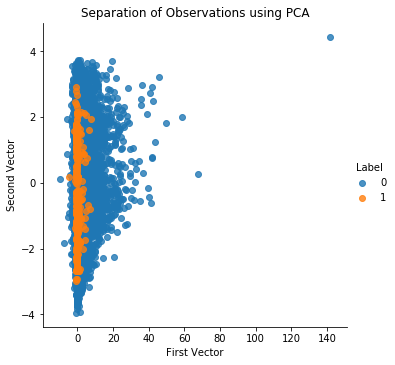

In [4]:
# 27 principal components
from sklearn.decomposition import PCA

n_components = 27
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)
X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)
scatterPlot(X_train_PCA, y_train, "PCA")


## Precision and Recall 
Precision and recall based on different threshold values for the anomalyScores

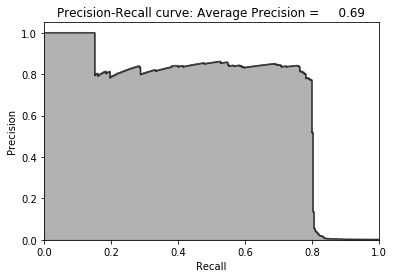

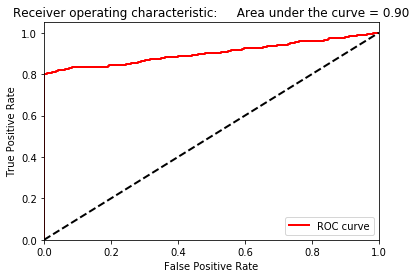

In [5]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

## Score Analysis

In [6]:
preds = pd.concat([y_train, anomalyScoresPCA], axis=1)
preds.columns = ['trueLabel', 'anomalyScore']
precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
  
average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])
        
cm = confusion_matrix(preds['trueLabel'], preds['anomalyScore']> 0.02)
print(cm)

preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))
print("Fraud Caught Identified:", predsTop.trueLabel.sum())


#preds.loc[preds['anomalyScore'] > 0.02,'trueLabel'].value_counts()

[[190417     73]
 [    69    261]]
Precision:  0.75
Recall:  0.8
Fraud Caught Identified: 264


## Plot the anomalies in the data

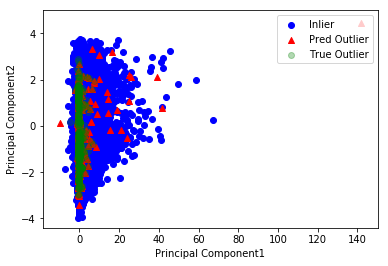

In [7]:
# Let's plot the data now
x = X_train_PCA[0]
y = X_train_PCA[1]
plt.scatter(x[preds['anomalyScore']<= 0.02],y[preds['anomalyScore']<= 0.02],marker='o',c='b',label='Inlier')
plt.scatter(x[preds['anomalyScore']> 0.02],y[preds['anomalyScore']> 0.02],marker='^',c='r',label='Pred Outlier')
plt.scatter(x[y_train == 1],y[y_train == 1],alpha=0.3,marker='o',c='g',label='True Outlier')
plt.legend(loc='upper right')
plt.xlabel("Principal Component1")
plt.ylabel("Principal Component2")

plt.show()

## Run PCA Model on the test data

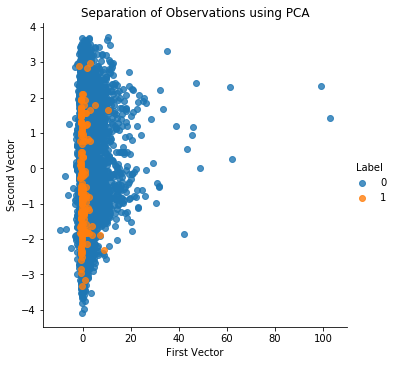

In [8]:
# PCA on Test Set
X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(data=X_test_PCA, index=X_test.index)

X_test_PCA_inverse = pca.inverse_transform(X_test_PCA)
X_test_PCA_inverse = pd.DataFrame(data=X_test_PCA_inverse, \
                                  index=X_test.index)
scatterPlot(X_test_PCA, y_test, "PCA")

## Plot the result on test data

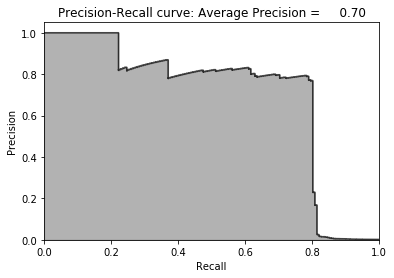

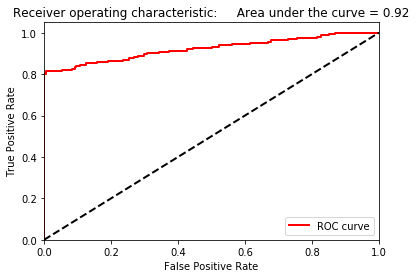

Precision:  0.82
Recall:  0.61
Fraud Caught Cases: 99


In [9]:
anomalyScorestestPCA = anomalyScores(X_test, X_test_PCA_inverse)
preds = plotResults(y_test, anomalyScorestestPCA, True)

preds = pd.concat([y_test, anomalyScorestestPCA], axis=1)
preds.columns = ['trueLabel', 'anomalyScorestestPCA']

precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScorestestPCA'])
    
average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScorestestPCA'])
        

cm = confusion_matrix(preds['trueLabel'], preds['anomalyScorestestPCA']> 0.02)
cm

preds.sort_values(by="anomalyScorestestPCA",ascending=False,inplace=True)
cutoff = 120
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScorestestPCA[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScorestestPCA[predsTop.trueLabel==1].count()/y_test.sum(),2))
print("Fraud Caught Cases:", predsTop.trueLabel.sum())


#preds.loc[preds['anomalyScore'] > 0.02,'trueLabel'].value_counts()

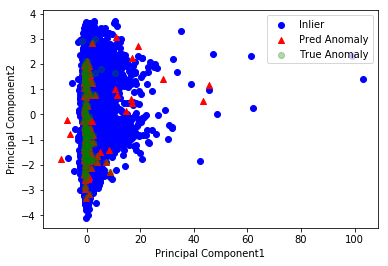

In [10]:
# Let's plot the data now
x = X_test_PCA[0]
y = X_test_PCA[1]

plt.scatter(x[preds['anomalyScorestestPCA']<= 0.02],y[preds['anomalyScorestestPCA']<= 0.02],marker='o',c='b',label='Inlier')
plt.scatter(x[preds['anomalyScorestestPCA']> 0.02],y[preds['anomalyScorestestPCA']> 0.02],marker='^',c='r',label= 'Pred Anomaly')
plt.scatter(x[y_test == 1],y[y_test == 1],alpha=0.3,marker='o',c='g',label = 'True Anomaly')
plt.legend(loc='upper right')
plt.xlabel("Principal Component1")
plt.ylabel("Principal Component2")
plt.show()